# Chat Intents

## UMAP + Clustering

In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

import umap

from tqdm.notebook import tqdm, trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

In [12]:
from sentence_transformers import SentenceTransformer

In [14]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 230.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 460.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 690.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 920.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [15]:
model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')

In [16]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [17]:
def embed_use(model, sentences):
    return model(sentences)

def embed_st(model, sentences):
    return model.encode(sentences)

In [30]:
embed_use(model_use, [data_sample.loc[0, 'text']]).shape

TensorShape([1, 512])

In [31]:
embed_st(model_st1, [data_sample.loc[0, 'text']]).shape

(1, 768)

In [32]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

## Clustering without dimensionality reduction

### K-means

In [8]:
def plot_kmeans(X, k_range):
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(X, kmeans.predict(X))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

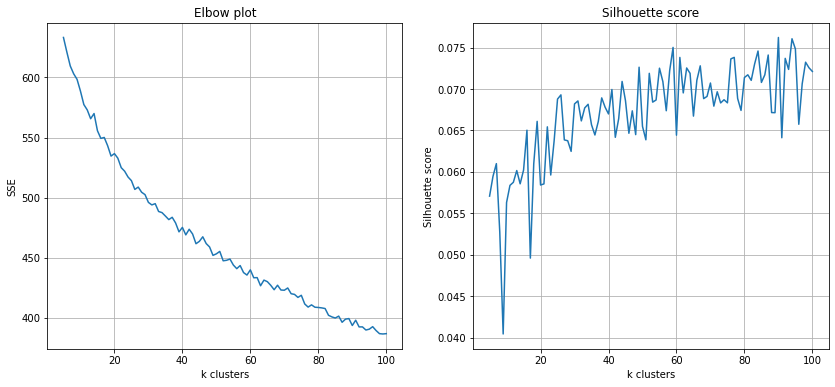

CPU times: user 42.9 s, sys: 1.7 s, total: 44.6 s
Wall time: 14.4 s


In [9]:
%%time

X = intents_embeddings
k_range = range(5, 101)

plot_kmeans(X, k_range)

### DBSCAN

In [10]:
db = DBSCAN(eps=0.25, min_samples=5, metric='cosine').fit(X)
labels = db.labels_
len(np.unique(labels))

21

In [11]:
len(labels)

1000

In [12]:
silhouette_score(X, labels, metric='cosine')

-0.19035175

In [94]:
def plot_dbscan(X, eps_range):
    silhouette_avg_n_clusters = []
    silhouette_avg = -1

    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=3, metric='cosine').fit(X)
        labels = db.labels_

        if len(np.unique(labels)) > 1:
            silhouette_avg = silhouette_score(X, labels, metric='cosine')
        else:
            silhouette_av = -1
        silhouette_avg_n_clusters.append(silhouette_avg)

    
    # plot avg silhouette score
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(eps_range, silhouette_avg_n_clusters)
    ax.set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    ax.grid()

    plt.show()

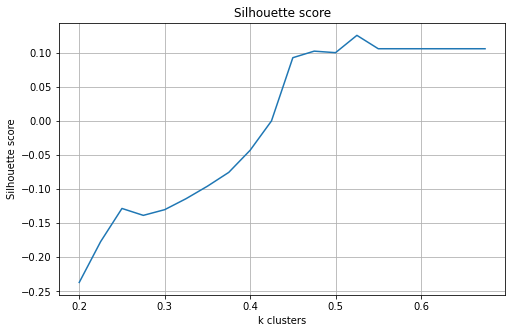

In [95]:
eps_range = np.arange(0.2, 0.7, 0.025)
plot_dbscan(X, eps_range)

In [96]:
db = DBSCAN(eps=0.5, min_samples=3, metric='cosine').fit(X)
labels = db.labels_
len(np.unique(labels))

3

In [97]:
silhouette_score(X, labels, metric='cosine')

0.099877276

### HDBSCAN

In [13]:
X = intents_embeddings
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(X)

labels = clusters_hdbscan.labels_
len(np.unique(labels))

204

In [14]:
np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)

355

## Clustering with dimensionality reduction

In [143]:
def generate_clusters(message_embeddings, 
                      n_neighbors = 4, 
                      n_components = 5, 
                      min_cluster_size = 4, 
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    cluster = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                              metric='euclidean', 
                              cluster_selection_method='eom').fit(umap_embeddings)
    return cluster

In [144]:
def score_clusters(n_repeats, message_embeddings, n_neighbors, n_components, min_cluster_size, random_state=None):
    """
    Returns average label count and average score over n_repeat runs
    """
    count_sum = 0
    score_sum = 0
    
    for i in range(n_repeats):
        clusters = generate_clusters(message_embeddings, n_neighbors, n_components, min_cluster_size, random_state)
        cluster_labels = clusters.labels_
        label_count = len(np.unique(cluster_labels))
        score = np.count_nonzero(clusters.probabilities_ < 0.05)
    
        count_sum += label_count
        score_sum += score
        
    avg_label_count = count_sum/n_repeats
    avg_score = score_sum/n_repeats
    
    return avg_label_count, avg_score

In [142]:
def scan_hyperparameters(all_intents, n_repeats):
    use_embeddings = embed_use(model_use, all_intents)
    
    results = []
    for n_neighbors in trange(3, 15, desc='n_neighbors'):
        for n_components in trange (3, 8, desc='n_components'):
            for min_cluster_size in trange(2, 10, desc='min_cluster_size'):
                
                avg_label_count, avg_score = score_clusters(n_repeats, n_neighbors, 
                                                            n_components, min_cluster_size)
                
                results.append([n_neighbors, n_components, min_cluster_size, avg_label_count, avg_score])
    
    result_df = pd.DataFrame(results, columns=['n_neighbors', 'n_components', 'min_cluster_size', 'avg_label_count', 'avg_score'])
    
    return result_df

In [ ]:
%%time
results_use = scan_hyperparameters(all_intents, 3)

In [35]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(3, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4)

CPU times: user 19.2 s, sys: 1.22 s, total: 20.5 s
Wall time: 16.2 s


(83.0, 140.33333333333334)

In [145]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(3, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4)

CPU times: user 15.7 s, sys: 1.73 s, total: 17.4 s
Wall time: 14 s


(80.0, 124.0)

In [146]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4, random_state=42)

CPU times: user 4.73 s, sys: 2.82 s, total: 7.54 s
Wall time: 11.8 s


(77.0, 125.0)

In [149]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4, random_state=42)

CPU times: user 3.07 s, sys: 101 ms, total: 3.17 s
Wall time: 2.7 s


(77.0, 125.0)

In [84]:
results_use

,n_neighbors,n_components,min_cluster_size,avg_label_count,avg_score
0,3,3,2,179,77.4


In [58]:
results_use[(results_use.score < 100)&(results_use.label_count < 100)&(results_use.label_count > 10)]

,n_neighbors,n_components,min_cluster_size,label_count,score
42,3,3,4,85,92
50,3,4,4,81,98
63,3,5,9,27,72
67,3,6,5,60,77


In [60]:
results_use.head()

,n_neighbors,n_components,min_cluster_size,label_count,score
0,2,3,2,201,97
1,2,3,3,147,152
2,2,3,4,104,247
3,2,3,5,87,226
4,2,3,6,70,230


In [71]:
use_embeddings = embed_use(model_use, all_intents)
num = 5
param_dict = [[4, 5, 4], 
              [3, 5, 9], 
              [3, 3, 4], 
              [3, 4, 4], 
              [3, 6, 6]]

for params in param_dict:
    count_sum = 0
    score_sum = 0
    
    for i in range(num):
        clusters = generate_clusters(use_embeddings, 
                                     n_neighbors = params[0], 
                                     n_components = params[1], 
                                     min_cluster_size = params[2])
        
        label_count, score = score_clusters(clusters)

        count_sum += label_count
        score_sum += score

    print(f"Avg number of clusters: {count_sum/num} . Avg score: {score_sum/num}")

Avg number of clusters: 85.8 . Avg score: 130.2
Avg number of clusters: 31.0 . Avg score: 178.6
Avg number of clusters: 86.6 . Avg score: 97.0
Avg number of clusters: 87.4 . Avg score: 104.2
Avg number of clusters: 53.2 . Avg score: 142.4


In [92]:
use_embeddings = embed_use(model_use, all_intents)
clusters = generate_clusters(use_embeddings, n_neighbors = 3, n_components = 3, min_cluster_size = 4)
label_count, score = score_clusters(clusters)
print(label_count)
print(score)

88
125


In [146]:
intents_df_use = pd.DataFrame(all_intents, columns=['message'])
intents_df_use['topic_use'] = clusters.labels_
intents_df_use.head(10)

,message,topic_use
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,64
1,I got charged a fee that shouldn't be there from my cash,79
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,86
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,67
4,Are there ways for other people to send me money?,13
5,How can I receive money?,13
6,where can I change my address?,21
7,What do I do if I still have not received my new card?,74
8,Is there anywhere I can't use my card?,54
9,I want to have multiple currencies in my account if possible.,42


In [140]:
st1_embeddings = embed_st(model_st1, all_intents)
clusters_st1 = generate_clusters(st1_embeddings, n_neighbors = 3, n_components = 3, min_cluster_size = 4)
label_count_st1, score_st1 = score_clusters(clusters_st1)
print(label_count_st1)
print(score_st1)

93
71


### Hyperopt optimization

In [76]:
from functools import partial

In [198]:
def objective(params, embeddings, random_state):
    
    avg_label_count, avg_score = score_clusters(1, embeddings, params['n_neighbors'], 
                                                params['n_components'], params['min_cluster_size'], random_state)
    
    if (avg_label_count < 30) | (avg_label_count > 100):
        penalty = 100
    else:
        penalty = 0
    
    score = avg_score + penalty
    
    return {'loss': score, 'label_count': avg_label_count, 'status': STATUS_OK}

In [199]:
def bayesian_search(embeddings, max_evals=100):
    
    space = {
        "n_neighbors": hp.choice('n_neighbors', list(range(3,16))),
        "n_components": hp.choice('n_components', list(range(3,16))),
        "min_cluster_size": hp.choice('min_cluster_size', list(range(2,15)))
    }
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, random_state=42)
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                #algo=partial(tpe.suggest, n_startup_jobs=20),#otherwise the first 20 will be random by default
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    return best_params, trials

In [175]:
use_embeddings = embed_use(model_use, all_intents)
use_best, _ = bayesian_search(use_embeddings, max_evals=50)

100%|██████████| 50/50 [03:21<00:00,  4.04s/trial, best loss: 84.0] 
best:
{'min_cluster_size': 4, 'n_components': 4, 'n_neighbors': 3}


In [206]:
use_embeddings = embed_use(model_use, all_intents)
use_best, _ = bayesian_search(use_embeddings, max_evals=100)

100%|██████████| 100/100 [06:56<00:00,  4.16s/trial, best loss: 97.0]
best:
{'min_cluster_size': 4, 'n_components': 12, 'n_neighbors': 3}
label count: 79.0


In [207]:
_.best_trial

{'state': 2,
 'tid': 15,
 'spec': None,
 'result': {'loss': 97.0, 'label_count': 79.0, 'status': 'ok'},
 'misc': {'tid': 15,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [15],
   'n_components': [15],
   'n_neighbors': [15]},
  'vals': {'min_cluster_size': [2], 'n_components': [9], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 9, 1, 12, 54, 0, 722000),
 'refresh_time': datetime.datetime(2021, 9, 1, 12, 54, 3, 990000)}

In [205]:
st1_embeddings = embed_st(model_st1, all_intents)
st1_best, _ = bayesian_search(st1_embeddings, max_evals=50)

100%|██████████| 50/50 [03:31<00:00,  4.24s/trial, best loss: 77.0]
best:
{'min_cluster_size': 3, 'n_components': 11, 'n_neighbors': 6}
label count: 98.0


In [216]:
use_clusters = generate_clusters(use_embeddings, 
                                 n_neighbors = use_best['n_neighbors'], 
                                 n_components = use_best['n_components'], 
                                 min_cluster_size = use_best['min_cluster_size'], 
                                 random_state=42)

In [209]:
st1_clusters = generate_clusters(st1_embeddings, 
                                 n_neighbors = st1_best['n_neighbors'], 
                                 n_components = st1_best['n_components'], 
                                 min_cluster_size = st1_best['min_cluster_size'], 
                                 random_state=42)

In [215]:
len(np.unique(st1_clusters.labels_))

98

In [166]:
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=3, n_components=4, min_cluster_size=4, random_state=42)

(84.0, 84.0)

In [170]:
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=4, n_components=11, min_cluster_size=4, random_state=42)

(83.0, 106.0)

In [187]:
st1_embeddings = embed_st(model_st1, all_intents)
score_clusters(1, st1_embeddings, n_neighbors=3, n_components=11, min_cluster_size=4, random_state=42)

(92.0, 80.0)

## Evaluate clusters

In [223]:
results_df = pd.DataFrame(all_intents, columns=['message'])
results_df['category'] = data_sample.category

cluster_dict = {'label_use': use_clusters, 
                'label_st1': st1_clusters}

for key, value in cluster_dict.items():
    results_df[key] = value.labels_
    
results_df.head()

,message,category,label_use,label_st1
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,65,44
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,-1,64
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,73,64
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,72,89
4,Are there ways for other people to send me money?,receiving_money,18,53


### Visually inspect clusters

In [241]:
def plot_clusters(embeddings, clusters, n_neighbors=4):
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = 0.0, 
                          metric='cosine', 
                          random_state=42).fit_transform(embeddings)

    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=4)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
    plt.colorbar()
    plt.show()

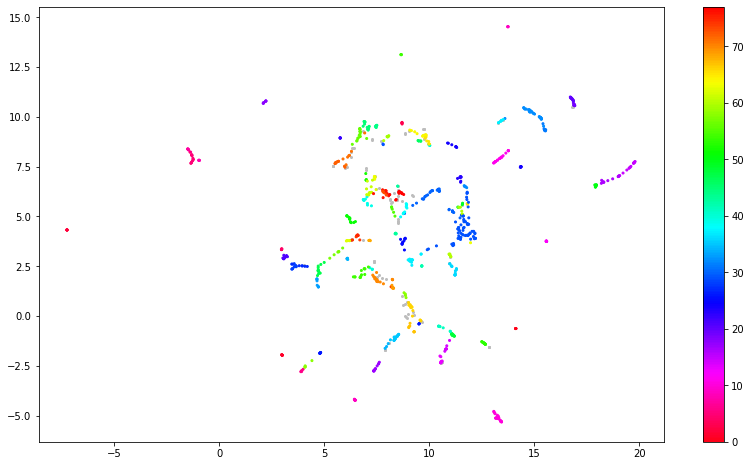

In [242]:
plot_clusters(use_embeddings, use_clusters, n_neighbors=4)

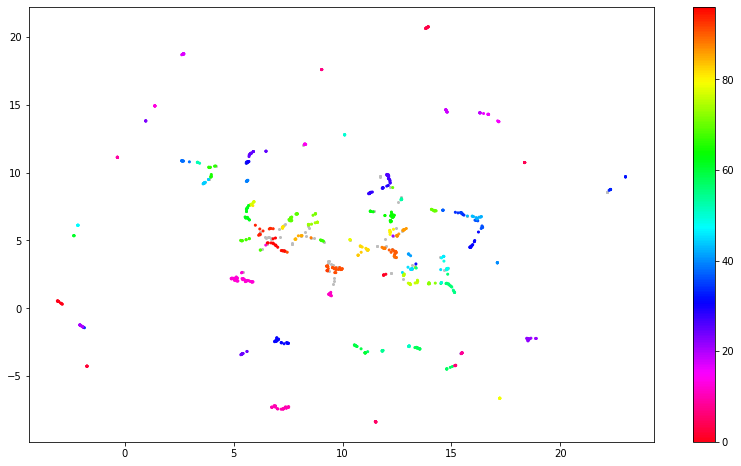

In [243]:
plot_clusters(st1_embeddings, st1_clusters, n_neighbors=4)

### Manually inspect category consistency

In [249]:
results_df[results_df['label_use']==2]

,message,category,label_use,label_st1
44,What are the countries you have offices in?,country_support,2,16
279,What countries are you available in?,country_support,2,16
295,What are the countries that you operate in?,country_support,2,16
503,Which countries do you operate in,country_support,2,16
600,How do I know which countries you provide service in?,country_support,2,16
898,I would like to know the countries you are offer services in?,country_support,2,16


In [245]:
results_df[results_df['category']=='country_support']

,message,category,label_use,label_st1
11,Do you do business in the EU?,country_support,41,15
44,What are the countries you have offices in?,country_support,2,16
122,Can I use this all over the world?,country_support,47,16
279,What countries are you available in?,country_support,2,16
295,What are the countries that you operate in?,country_support,2,16
311,Can I get a card in the EU?,country_support,41,61
503,Which countries do you operate in,country_support,2,16
600,How do I know which countries you provide service in?,country_support,2,16
724,"I'm not in the UK, but can I still get a card?",country_support,41,61
732,Can I get support?,country_support,32,53


Both USE and ST1 models have high precision for `country_support` category but also both miss many instances in that group.

In [250]:
results_df[results_df['category']=='card_about_to_expire']

,message,category,label_use,label_st1
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,35,25
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,35,25
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,9,25
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,9,25
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,9,25
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,9,25
551,Where can I have a new bank card sent to China?,card_about_to_expire,35,25
584,How do I get a new expiration date?,card_about_to_expire,9,25
605,Are there any express fees if i want my new card faster?,card_about_to_expire,-1,25
646,My card is almost going to expire.,card_about_to_expire,9,25


In [251]:
results_df[results_df['label_st1']==25]

,message,category,label_use,label_st1
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,35,25
108,I would like to purchase another card.,getting_spare_card,66,25
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,35,25
383,What is the price for an additional card?,getting_spare_card,-1,25
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,9,25
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,9,25
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,9,25
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,9,25
551,Where can I have a new bank card sent to China?,card_about_to_expire,35,25
584,How do I get a new expiration date?,card_about_to_expire,9,25


### Manually inspect category consistency with ground truth labels

In [261]:
def comparison_table(model_dict, results_df):
    summary = []

    for key, value in model_dict.items():
        ari = np.round(adjusted_rand_score(results_df['category'].values, results_df[value].values), 3)
        nmi = np.round(normalized_mutual_info_score(results_df['category'].values, results_df[value].values), 3)
        summary.append([key, ari, nmi])

    comparison_df = pd.DataFrame(results, columns=['Model','ARI', 'NMI'])
    
    return comparison_df

In [262]:
model_dict = {'USE': 'label_use', 
              'Sent-Transformer_1': 'label_st1'}

comparison_table(model_dict, results_df)

,Model,ARI,NMI
0,USE,0.268,0.725
1,Sent-Transformer_1,0.410,0.798
